# Ames Housing Analysis - Cleaning and EDA

# 1. Executive Summary <a id='Executive_Summary'></a>

### 1.1 Problem Statement

<a id='Problem_Statement'></a>
For this project, I have two goals:

    1) Determine the best model for predicting Sale Price for houses in Ames using up to 25 features from the data set
    2) Determine what the most important features are for said prediction
    
Specifically, we want a model that has high predictive power (R2 > 0.8), but generalizes well to new data. Furthermore, we want to select a reasonable (<25) number of features to ensure that the model does not become too complicated or overfitted.

### 1.2 Table of Contents

- <a href='#Executive_Summary'>1. Executive Summary</a>
    - <a href='#Problem_Statement'>1.1 Problem Statement</a>
- <a href='#Data_Dictionary'>2. Data Dictionary</a>
- <a href='#Data_Import'>3. Data Import and Cleaning</a>
    - <a href='#Library_Imports'>3.1 Library Imports</a>
    - <a href='#Data_Imports'>3.2 Data Imports</a>    
    - <a href='#Overview_of_Imported_Data'>3.3 Overview of Imported Data</a>
    - <a href='#Functions_and_Pipelines'>3.4 Functions and Pipelines for Cleaning</a>    
    - <a href='#Data_Cleaning'>3.5 Data Cleaning</a>    
- <a href='#EDA'>4. Exploratory Data Analysis</a>
    - <a href='#Distributions'>4.1 Distribution Visualizations</a>    
        - <a href='#Histograms'>4.1.1 Histograms</a>
        - <a href='#bars'>4.1.2 Bar Plots</a>           
        - <a href='#boxplots'>4.1.3 Box Plots</a>
    - <a href='#correlations'>4.2 Correlation Visualizations</a>    
        - <a href='#scatter'>4.2.1 Scatter Plots</a>
        - <a href='#heat'>4.2.2 Heatmaps</a>
- <a href='#prep'>5. Encoding and Preprocessing</a>    
    - <a href='#outliers'>5.1 Removing Outliers</a>  
    - <a href='#binary'>5.2 Encoding Dichotomous Variables</a>
    - <a href='#dummy'>5.3 Get Dummies</a>  
- <a href='#export'>6. Data Export</a>    

# 2. Data Dictionary <a id='Data_Dictionary'></a>

A concise summary of the data can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# 3. Data Import and Cleaning <a id='Data_Import'></a>

### 3.1 Library Imports <a id='Library_Imports'></a>

In [1]:
#Imports:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, BayesianRidge, ElasticNetCV, ElasticNet
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, Imputer, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

### 3.2 Data Imports <a id='Data_Imports'></a>

In [2]:
df_train = pd.read_csv (r'.\datasets\train.csv')
df_test = pd.read_csv (r'.\datasets\test.csv')
df_sample = pd.read_csv (r'.\datasets\sample_sub_reg.csv')

In [3]:
df_train.head(1)

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  

[1 rows x 81 columns]

Column headings in raw csv are capitalized and have spaces.

I will remove capitalizing and replace spaces with underscores for easier processing.

In [4]:
df_train.columns = [item.lower() for item in df_train.columns.str.replace(" ", "_")]

In [5]:
df_test.columns = [item.lower() for item in df_test.columns.str.replace(" ", "_")]

### 3.3 Overview of Imported Data <a id='Overview_of_Imported_Data'></a>

In this section, I cover the structure and datatypes in the imported dataframes, as well as gauge the overall cleanliness and useability of the data.

In [6]:
#The dataframe has 81 columns. Pandas truncates our data view by default, 
#so this line of code allows us to view all columns.
pd.options.display.max_columns = None

In [7]:
df_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
id                 2051 non-null int64
pid                2051 non-null int64
ms_subclass        2051 non-null int64
ms_zoning          2051 non-null object
lot_frontage       1721 non-null float64
lot_area           2051 non-null int64
street             2051 non-null object
alley              140 non-null object
lot_shape          2051 non-null object
land_contour       2051 non-null object
utilities          2051 non-null object
lot_config         2051 non-null object
land_slope         2051 non-null object
neighborhood       2051 non-null object
condition_1        2051 non-null object
condition_2        2051 non-null object
bldg_type          2051 non-null object
house_style        2051 non-null object
overall_qual       2051 non-null int64
overall_cond       2051 non-null int64
year_built         2051 non-null int64
year_remod/add     2051 non-null int64
roof_style         20

In [8]:
df_train.shape

(2051, 81)

In [9]:
df_test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
id                 879 non-null int64
pid                879 non-null int64
ms_subclass        879 non-null int64
ms_zoning          879 non-null object
lot_frontage       719 non-null float64
lot_area           879 non-null int64
street             879 non-null object
alley              58 non-null object
lot_shape          879 non-null object
land_contour       879 non-null object
utilities          879 non-null object
lot_config         879 non-null object
land_slope         879 non-null object
neighborhood       879 non-null object
condition_1        879 non-null object
condition_2        879 non-null object
bldg_type          879 non-null object
house_style        879 non-null object
overall_qual       879 non-null int64
overall_cond       879 non-null int64
year_built         879 non-null int64
year_remod/add     879 non-null int64
roof_style         879 non-null object
roof_m

In [10]:
df_test.shape

(879, 80)

In [11]:
pd.DataFrame(data = [df_train.dtypes, df_test.dtypes], index = ["df_train", "df_test"])

id    pid ms_subclass ms_zoning lot_frontage lot_area  street  \
df_train  int64  int64       int64    object      float64    int64  object   
df_test   int64  int64       int64    object      float64    int64  object   

           alley lot_shape land_contour utilities lot_config land_slope  \
df_train  object    object       object    object     object     object   
df_test   object    object       object    object     object     object   

         neighborhood condition_1 condition_2 bldg_type house_style  \
df_train       object      object      object    object      object   
df_test        object      object      object    object      object   

         overall_qual overall_cond year_built year_remod/add roof_style  \
df_train        int64        int64      int64          int64     object   
df_test         int64        int64      int64          int64     object   

         roof_matl exterior_1st exterior_2nd mas_vnr_type mas_vnr_area  \
df_train    object       object       object       object      float64   
df_test     object       object       object       object      float64   

         exter_qual exter_cond foundation bsmt_qual bsmt_cond bsmt_exposure  \
df_train     object     object     object    object    object        object   
df_test      object     object     object    object    object        object   

         bsmtfin_type_1 bsmtfin_sf_1 bsmtfin_type_2 bsmtfin_sf_2 bsmt_unf_sf  \
df_train         object      float64         object      float64     float64   
df_test          object        int64         object        int64       int64   

         total_bsmt_sf heating heating_qc central_air electrical 1st_flr_sf  \
df_train       float64  object     object      object     object      int64   
df_test          int64  object     object      object     object      int64   

         2nd_flr_sf low_qual_fin_sf gr_liv_area bsmt_full_bath bsmt_half_bath  \
df_train      int64           int64       int64        float64        float64   
df_test       int64           int64       int64          int64          int64   

         full_bath half_bath bedroom_abvgr kitchen_abvgr kitchen_qual  \
df_train     int64     int64         int64         int64       object   
df_test      int64     int64         int64         int64       object   

         totrms_abvgrd functional fireplaces fireplace_qu garage_type  \
df_train         int64     object      int64       object      object   
df_test          int64     object      int64       object      object   

         garage_yr_blt garage_finish garage_cars garage_area garage_qual  \
df_train       float64        object     float64     float64      object   
df_test        float64        object       int64       int64      object   

         garage_cond paved_drive wood_deck_sf open_porch_sf enclosed_porch  \
df_train      object      object        int64         int64          int64   
df_test       object      object        int64         int64          int64   

         3ssn_porch screen_porch pool_area pool_qc   fence misc_feature  \
df_train      int64        int64     int64  object  object       object   
df_test       int64        int64     int64  object  object       object   

         misc_val mo_sold yr_sold sale_type saleprice  
df_train    int64   int64   int64    object     int64  
df_test     int64   int64   int64    object       NaN

The dataframe above captures the datatypes for each column. In general, all of the columns have appropriate datatypes. Certain columns with ordinal values will be encoded into Likert Scales (e.g. rating from 1 to 5).

The datatypes for some of the columns do not tally between the test and train sets either - the bsmt, garage, bath features  are stored as floats in the train df, while they are stored as int in the test set. Additionally, the test set does not have a saleprice column.

From glancing at the info() summaries of the dataframes above, it is apparently that the datasets comprise of a significant number of null values. I will quantify the extent of the missing data below.

In [12]:
#Checking for nulls
null_counts = df_train.isnull().sum().to_frame(name="nullcount")
df_train_nulls = null_counts[null_counts["nullcount"]>0].transpose()
df_train_nulls

lot_frontage  alley  mas_vnr_type  mas_vnr_area  bsmt_qual  \
nullcount           330   1911            22            22         55   

           bsmt_cond  bsmt_exposure  bsmtfin_type_1  bsmtfin_sf_1  \
nullcount         55             58              55             1   

           bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  \
nullcount              56             1            1              1   

           bsmt_full_bath  bsmt_half_bath  fireplace_qu  garage_type  \
nullcount               2               2          1000          113   

           garage_yr_blt  garage_finish  garage_cars  garage_area  \
nullcount            114            114            1            1   

           garage_qual  garage_cond  pool_qc  fence  misc_feature  
nullcount          114          114     2042   1651          1986

In [13]:
null_counts = df_test.isnull().sum().to_frame(name="nullcount")
df_test_nulls = null_counts[null_counts["nullcount"]>0].transpose()
df_test_nulls

lot_frontage  alley  mas_vnr_type  mas_vnr_area  bsmt_qual  \
nullcount           160    821             1             1         25   

           bsmt_cond  bsmt_exposure  bsmtfin_type_1  bsmtfin_type_2  \
nullcount         25             25              25              25   

           electrical  fireplace_qu  garage_type  garage_yr_blt  \
nullcount           1           422           44             45   

           garage_finish  garage_qual  garage_cond  pool_qc  fence  \
nullcount             45           45           45      875    707   

           misc_feature  
nullcount           838

In [14]:
print("df_train has {} columns with null values!".format(len(df_train_nulls.columns)))
print("df_train has {} total null values!".format(df_train.isnull().sum().sum()))
print("df_test has {} columns with null values!".format(len(df_test_nulls.columns)))
print("df_test has {} total null values!".format(df_test.isnull().sum().sum()))

df_train has 26 columns with null values!
df_train has 9822 total null values!
df_test has 19 columns with null values!
df_test has 4175 total null values!


The dataframe below captures the null count for each column in the training dataset.
There are 26 columns with null values, out of a total of 81 columns, and a total of 9822 nulls. Because this number is significant, I will not be dropping any of these rows.

From the data dictionary, the following table captures the interpretation of nulls in each columns.

Special note for the basement values - although NAN represents no basement, the number of NANs in each column do not add up. For example, bsmt_qual is 55 nulls, while bsmt_exposure has 58 nulls. However, the number of actual NANs (i.e. the data is actually missing) is very low (approximately 3 missing values out of a total of 2051). As such, I will replace these values with 0 since the impact on overal data quality is minimal.

|Feature|Type|Description|Analysis|
|---|---|---|---|
|lot_frontage|Continuous|Lot size in square feet| 330 missing values - fill using imputer|
|alley|Nominal|Type of alley access to property| NAN represents no alley access - replace NAN with 0.|
|mas_vnr_type|Nominal|Masonry veneer type| NAN represents missing values - fill using imputer|
|mas_vnr_area|Continuous|Masonry veneer area in square feet| NAN represents missing values - fill with most frequent (which is 0)|
|bsmt_qual|Ordinal|Evaluates the height of the basement| NAN represents no basement - replace NAN with 0|
|bsmt_cond|Ordinal|Evaluates the general condition of the basement|NAN represents no basement - replace NAN with 0|
|bsmtfin_type_1|Ordinal|Rating of basement finished area|NAN represents no basement - replace NAN with 0|
|bsmtfin_sf_1|Continuous|Type 1 finished square feet|1 missing value - replace with 0 (i.e. assume no basement)|
|bsmtfin_type_2|Ordinal|Rating of basement finished area (if multiple types)| NAN represents no basement|
|bsmt_unf_sf|Continuous|Unfinished square feet of basement area| 1 missing value - replace with 0 (i.e. assume no basement)|
|total_bsmt_sf|Continuous|Total square feet of basement area|1 missing value - replace with 0 (i.e. assume no basement)|
|bsmt_full_bath|Discrete|Basement full bathrooms|2 missing values - replace with 0 (i.e. assume no basement)|
|bsmt_half_bath|Discrete|Basement half bathrooms|2 missing values - replace with 0 (i.e. assume no basement)|
|fireplace_qu|Ordinal|Fireplace quality|NAN represents no fireplace - replace with 0|
|garage_type|Nominal|Garage location|NAN represents no garage - replace with 0|
|garage_yr_blt|Discrete|Year garage was built|NAN represents no garage - keep as is, as we will create a new column to capture garage age|
|garage_finish|Ordinal|Interior finish of the garage|NAN represents no garage - replace with 0|
|garage_cars|Discrete|Size of garage in car capacity|1 missing value - replace with 0|
|garage_area|Continuous|Size of garage in square feet|1 missing value - replace with 0|
|garage_qual|Ordinal|Garage quality|NAN represents no garage - replace with 0|
|garage_cond|Ordinal|Garage condition|NAN represents no garage - replace with 0|
|pool_qc|Ordinal|Pool quality|NAN represents no pool - replace with 0|
|fence|Ordinal|Fence quality|NAN represents no fence - replace with 0|
|misc_feature|Nominal|Miscellaneous feature not covered in other categories|NAN represents none - replace with 0|

### 3.4 Functions and Pipelines for Data Cleaning and Encoding <a id='Functions_and_Pipelines'></a>

In [15]:
#Removes duplicates and prints out number of duplicates removed
def remove_duplicates(my_df):
    before_d = len(my_df)
    my_df.drop_duplicates(inplace=True)
    after_d = len(my_df)
    print(str(before_d-after_d) + " duplicates were removed!")

In [16]:
#Generates a one column "heatmap" that highlights the top n correlations for a particular feature.
#Used as a quick feature selection heuristic
def quick_heat(my_df, feature, n=10):
    plt.figure(figsize=(15, n*0.6))
    data = pd.DataFrame(my_df.corr()[feature].abs().sort_values(ascending=False)).drop([feature,"saleprice"], axis = 0).head(n)
    sns.heatmap(data, cmap="YlGnBu", annot=True).set_title("Correlations to {} (Absolute Value)".format(feature))

In [17]:
def iterative_fill(my_df, feature, est = LinearRegression(fit_intercept=True)):
    #This function uses sklearn's iterative fill to imput missing values.
    imp = IterativeImputer(missing_values = np.nan, estimator = est, max_iter=100, random_state=0)
    rs = RobustScaler()
    
    #Generate a dataframe with saleprice dropped, since this is our dependent variable.
    #Because we haven't gotten dummies at this stage, we will predict missing values using only non-categorical/nominal data.
    
    #Creates a subset of the dataframe with only floats/int, because iterativeimputer can't handle strings
    #Also, I do not want to have another pipeline here to make things confusing
    num_cols = [col for col in my_df.columns if my_df[col].dtype=="float64" or my_df[col].dtype=="int64"]
    #remove saleprice to prevent data leakage, if sale price column exists
    try:
        X = my_df[num_cols].drop(["saleprice"], axis = 1)
    except:
        X = my_df[num_cols]
        
    #standardizes data in X, before applying the imputer
    rs.fit_transform(X)
    imp.fit(X)
    
    #Apply transformation to entire dataframe - 
    #Basically, this runs a regression for the feature with missing values against all other features.
    #It then fills the missing values with the prediction made from the regression.
    
    imp_data = pd.DataFrame(np.round(imp.transform(X), decimals = 0), columns = X.columns)
    
    #Cross val scores for regression to validate model used to impute
    mean_mse = -cross_val_score(est, imp_data.drop(feature, axis = 1), imp_data[feature], 
                           scoring='neg_mean_squared_error', cv=10).mean()
    mean_r2 = cross_val_score(est, imp_data.drop(feature, axis =1), imp_data[feature], scoring='r2', cv=10).mean()
    
    print("Mean MSE: {}, Mean R2: {}".format(mean_mse, mean_r2))
    
    #When this code runs, it actually applies the regression logic to ALL MISSING VALUES in the df.
    #I don't want all the imputed values, just the imputed values for the feature selected in the function.
    #This retains the flexibility to run a different regression for other features, though this is computationally expensive.
    
    #Return only the column with the feature so you can assign it back to your main dataframe
    return imp_data[feature]

### 3.5 Data Cleaning <a id='Data_Cleaning'></a>

Check for and remove duplicates.

In [18]:
remove_duplicates(df_train)
remove_duplicates(df_test)

0 duplicates were removed!
0 duplicates were removed!


Replace null values with 0 for the columns highlighted in the analysis table above.

In [19]:
#list of columns to replace with imputed values
fill_impute = ["lot_frontage", "mas_vnr_type", "mas_vnr_area"]

#list of columns to replace with 0
fill_zero_train = [col for col in df_train_nulls.columns if not col in fill_impute]
fill_zero_test = [col for col in df_test_nulls.columns if not col in fill_impute]

In [20]:
#replace all NANs in df_train fill_zero list with 0
nans_removed = df_train[fill_zero_train].isnull().sum().sum() - df_train[fill_zero_train].fillna(0).isnull().sum().sum()
df_train[fill_zero_train] = df_train[fill_zero_train].fillna(0)
print("{} null values were replaced!".format(nans_removed))

9448 null values were replaced!


In [21]:
#replace all NANs in df_test fill_zero list with 0
nans_removed = df_test[fill_zero_test].isnull().sum().sum() - df_test[fill_zero_test].fillna(0).isnull().sum().sum()
df_test[fill_zero_test] = df_test[fill_zero_test].fillna(0)
print("{} null values were replaced!".format(nans_removed))

4013 null values were replaced!


The following features contain ordinal data stored as strings, and can be broadly considered as "ratings". This information may be converted into numerical values, similar to that of a likert scale.

TO DO: Possible logistic regression

|Feature|Type|Description|Current Values|To be replaced with|
|---|---|---|---|---|
|exter_qual|Ordinal|Evaluates the quality of the material on the exterior |"Ex", "Gd", "TA", "Fa", "Po"| 5, 4, 3, 2, 1 |
|exter_cond|Ordinal|Evaluates the present condition of the material on the exterior|"Ex", "Gd", "TA", "Fa", "Po"| 5, 4, 3, 2, 1|
|bsmt_qual|Ordinal|Evaluates the height of the basement|"Ex", "Gd", "TA", "Fa", "Po", "NA"| 5, 4, 3, 2, 1, 0|
|bsmt_cond|Ordinal|Evaluates the general condition of the basement|"Ex", "Gd", "TA", "Fa", "Po", "NA"| 5, 4, 3, 2, 1, 0|
|bsmtfin_type_1|Ordinal|Rating of basement finished area|"GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"| 6, 5, 4, 3, 2, 1, 0|
|bsmtfin_type_2|Ordinal|Rating of basement finished area|"GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"| 6, 5, 4, 3, 2, 1, 0|
|heating_qc|Ordinal|Heating quality and condition|"Ex", "Gd", "TA", "Fa", "Po"| 5, 4, ,3, 2, 1 |
|kitchen_qual|Ordinal|Kitchen quality|"Ex", "Gd", "TA", "Fa", "Po"| 5, 4, ,3, 2, 1 |
|fireplace_qu|Ordinal|Fireplace quality|"Ex", "Gd", "TA", "Fa", "Po", "NA"| 5, 4, 3, 2, 1, 0|
|garage_qual|Ordinal|Garage quality|"Ex", "Gd", "TA", "Fa", "Po", "NA"| 5, 4, 3, 2, 1, 0|
|garage_cond|Ordinal|Garage condition|"Ex", "Gd", "TA", "Fa", "Po", "NA"| 5, 4, 3, 2, 1, 0|
|pool_qc|Ordinal|Pool quality| "Ex", "Gd", "TA", "Fa", "Po", "NA"| 5, 4, 3, 2, 1, 0|

In [22]:
#Dictionary to map values to
#Note that because fillna was done in the previous step, 0s are mapped to 0.
rating_dict = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 
               "GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "NA":0, 0:0}

In [23]:
#List of columns to convert from string to integer
#Note that NOT ALL ORDINAL DATA should be converted - some are to be retained as strings.
ord_list = ["exter_qual", "exter_cond", "bsmt_qual", "bsmt_cond", "bsmtfin_type_1", "bsmtfin_type_2",
           "heating_qc", "kitchen_qual", "fireplace_qu", "garage_qual", "garage_cond", "pool_qc"]
df_train[ord_list] = df_train[ord_list].applymap(lambda x: rating_dict[x])
df_test[ord_list] = df_test[ord_list].applymap(lambda x: rating_dict[x])

Create new dataframe columns for building age, remodel age, and garage age; drop year built, year remod/add and drop garage yr blt columns.

In [24]:
#New column for building age, determined by year sold - year built
df_train["bldg_age"] = df_train["yr_sold"] - df_train["year_built"]
df_test["bldg_age"] = df_test["yr_sold"] - df_test["year_built"]

#New column for years since remodel, determined by year sold - year remodeled
df_train["remodel_age"] = df_train["yr_sold"] - df_train["year_remod/add"]
df_test["remodel_age"] = df_test["yr_sold"] - df_test["year_remod/add"]

#New column for garage age, determined by year sold - year remodeled
df_train["garage_age"] = df_train["yr_sold"] - df_train["garage_yr_blt"]
df_test["garage_age"] = df_test["yr_sold"] - df_test["garage_yr_blt"]

#Because garage_age nullvalues were filled with 0, their age is over 2000.
#This function maps them back to 0
df_train["garage_age"] = df_train["garage_age"].apply(lambda x: 0 if x > 2000 or x < 0 else x)
df_test["garage_age"] = df_test["garage_age"].apply(lambda x: 0 if x > 2000 or x < 0 else x)

In [25]:
#Drop redundant columns. 
#In addition to the year built columns, I will also drop the PID column as the data is not useful.
df_train = df_train.drop(["pid", "year_built", "year_remod/add", "garage_yr_blt"], axis = 1)
df_test = df_test.drop(["pid", "year_built", "year_remod/add", "garage_yr_blt"], axis = 1)

For the columns with a significant number of missing values, I will be using sklearn's imputer.
lot_frontage and mas_vnr_area are continuous variables - I will use an iterative imputer to fill with predicted values.

Note - for the dataframe used in the function, I'm using a subset where features in the nominal_list are dropped. As explained, I retain the original columns for purpose of EDA, and I will be dropping this during the preprocessing stage.

In [26]:
nominal_list = [col for col in df_train.columns if df_train[col].dtype=="object"]

In [27]:
df_train["lot_frontage"] = iterative_fill(df_train.drop(nominal_list, axis = 1), "lot_frontage", est = LinearRegression())

Mean MSE: 257.37866803966375, Mean R2: 0.5306527857088243


In [28]:
df_train["mas_vnr_area"] = iterative_fill(df_train.drop(nominal_list, axis = 1), "mas_vnr_area", est = LinearRegression())

Mean MSE: 21377.182616503975, Mean R2: 0.2968323140454593


In [29]:
nominal_list = [col for col in df_test.columns if df_train[col].dtype=="object"]

In [30]:
df_test["lot_frontage"] = iterative_fill(df_test.drop(nominal_list, axis = 1), "lot_frontage", est = LinearRegression())

Mean MSE: 281.4787764173637, Mean R2: 0.4461956302038287


In [31]:
df_test["mas_vnr_area"] = iterative_fill(df_test.drop(nominal_list, axis = 1), "mas_vnr_area", est = LinearRegression())

Mean MSE: 28313.160886913643, Mean R2: 0.18859949754617406


The R2s for the imputed values are not ideal - when performing further fine tuning it is advisable to try further stategies to refine this. Bayesian ridge/random forests may be a good strategy, but for simplicity I will be using a simple linear regression to impute.

Furthermore, an R2 greater of 0 implies that this is imputation is a better fit than simply using the mean.

In [32]:
#Because mas_vnr_type is a nominal value, I use sklearn's simpleimputer to fill missing values with the mode.
modal_imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
df_train["mas_vnr_type"] = modal_imputer.fit_transform(df_train[["mas_vnr_type"]]).ravel()

In [33]:
modal_imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
df_test["mas_vnr_type"] = modal_imputer.fit_transform(df_test[["mas_vnr_type"]]).ravel()

In [34]:
#Checking if there are any nulls left in the dataframe
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0


# 4. Exploratory Data Analysis <a id='EDA'></a>

## 4.1 : Distribution Visualizations and Analysis<a id='Distribution'></a>
### 4.1.1 Histograms<a id='Histograms'></a>

In [35]:
plt.style.use('ggplot')
def subplot_histograms(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    
    #Scales the height of the fig to accomodate a long list of features    
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, len(list_of_columns)*3)) 
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column], ax=ax[i], bins = 20, fit=norm, kde=True) 
        mean_val = dataframe[column].mean()
        
        #runs D’Agostino's normality test to print on graph
        normality_test = stats.normaltest(df_train[column]).pvalue < 0.05
        ax[i].set_title("Histogram for {}".format(list_of_columns[i]))
        ax[i].set_xlabel(list_of_columns[i]) 
        ax[i].axvline(x = mean_val, label = "mean", color = "darkred").set_linestyle("--")
        ax[i].text(0.75, 0.83, "Normal: {}".format(not normality_test), ha="left", va="top", transform=ax[i].transAxes, fontsize=12)
        ax[i].legend()

In [36]:
#Plot histograms for all features that are floats or integers
list_of_columns = [i for i in df_train.columns if df_train[i].dtype=="float64" or df_train[i].dtype=="int64"]

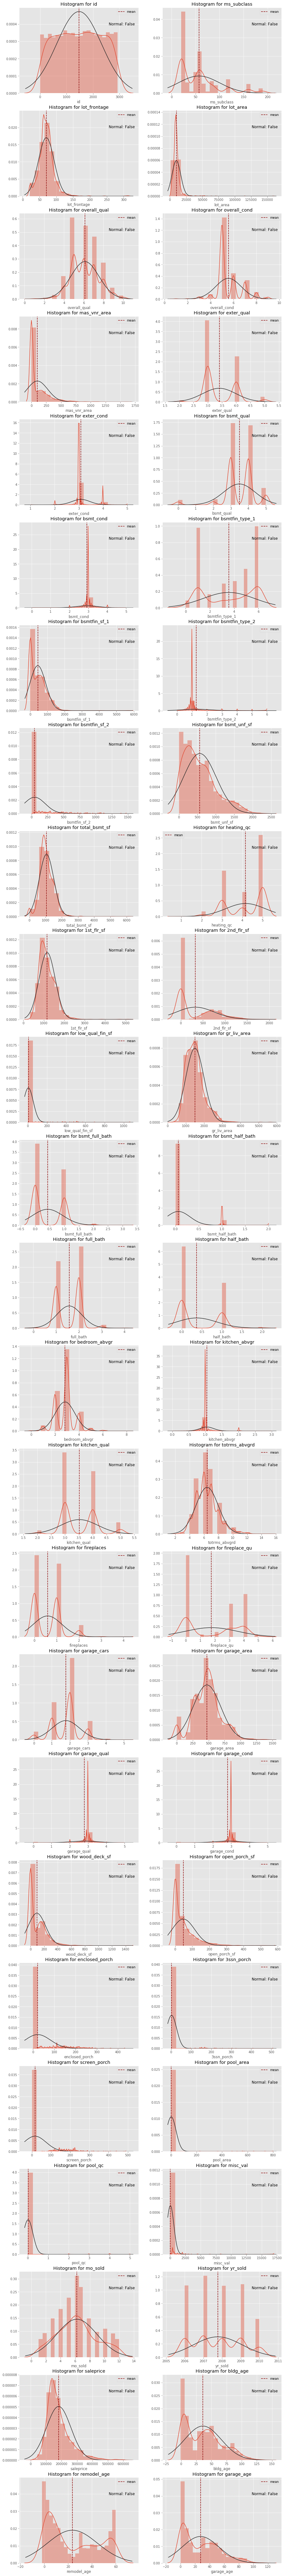

In [37]:
#Note - this takes awhile to run due to the number of features selected (est 20s)
subplot_histograms(df_train, list_of_columns)

#### Interpretation of Histograms

From the graphs above I make three observations:

     1) None of the float/int features are normally distributed.
        The tests above use D'agostino's normality test with an alpha of 0.05. i.e. If "Normal: False", we reject the null
        hypothesis that x comes from a normal distribution.
        
     2) Much of the data here is heavily skewed right, due to the nature of encoding. The absence of a feature is encoded 
        as 0, so this is to be somewhat expected. This results in bimodal or multimodal distributions - for example, 
        the peak at 0 captures those that lack a feature (i.e. feature value = 0), whilst the other population (the
        subsequent peak) captures those who have that feature.
     
     3) Outliers are present in the data, as implied by some of the heavily skewed distributions - e.g. there are two houses
        with 1st_flr_sf > 4500, when the mean is 1100! This will be further explored in the boxplot section.

### 4.1.2 Bar plots <a id='bars'></a>

In [38]:
plt.style.use('seaborn-white')
def subplot_bars(dataframe, list_of_columns):
    #Creates two subplots based on the number of values inside the columns.
    #Columns with a large number of unique values are plotted in subplot 1, while the rest are plotted in subplot 2
    long_col = []
    short_col = []
    
    #divides columns into those >=10 uniquevals and those with <10
    for n in list_of_columns:
        if dataframe[n].nunique() >= 10:
            long_col.append(n)
        else:
            short_col.append(n)
            
    #Makes sure there are enough rows for both plots
    nrow_long = int(np.ceil(len(long_col)))
    nrow_short = int(np.ceil(len(short_col)/2))

    #Scales the height of the fig to accomodate a long list of features
    #Figsize vals can be tweaked if the fit is wrong
    fig1, ax1 = plt.subplots(nrows=nrow_long, ncols=1, figsize=(30, len(long_col)*12)) 
    fig2, ax2 = plt.subplots(nrows = nrow_short, ncols = 2, figsize=(15, len(short_col)*4))
    ax1 = ax1.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    ax2 = ax2.ravel()
                             
    for i, column in enumerate(long_col): # Gives us an index value to get into all our lists
        #find the count of the most frequently occuring category, and express it as a fraction of total count
        mode_perc = np.round(dataframe[column].value_counts().max()/dataframe[column].value_counts().sum(), 2)
        sns.countplot(dataframe[column], ax=ax1[i]) 
        ax1[i].set_title("Countplot for {}".format(long_col[i]), fontsize= 20)
        ax1[i].set_xlabel(long_col[i]) 
        #print mode count and perc of total count in the middle of the graph
        ax1[i].text(0.5, 0.5, "Mode accounts for {} of total count".format(mode_perc), fontsize=14,
                   ha= "center", va="center", transform=ax1[i].transAxes)
        
    for i, column in enumerate(short_col): # Gives us an index value to get into all our lists
        #find the count of the most frequently occuring category, and express it as a fraction of total count        
        mode_perc = np.round(dataframe[column].value_counts().max()/dataframe[column].value_counts().sum(), 2)
        sns.countplot(dataframe[column], ax=ax2[i]) 
        ax2[i].set_title("Countplot for {}".format(short_col[i]), fontsize = 12)
        ax2[i].set_xlabel(short_col[i])
        #print mode count and perc of total count in the middle of the graph
        ax2[i].text(0.5, 0.5, "Mode accounts for {} of total count".format(mode_perc), fontsize=10, 
                    ha= "center", va="center", transform=ax2[i].transAxes)


In [39]:
#Plot bar charts for all features that are objects
list_of_columns = [i for i in df_train.columns if df_train[i].dtype=="object"]

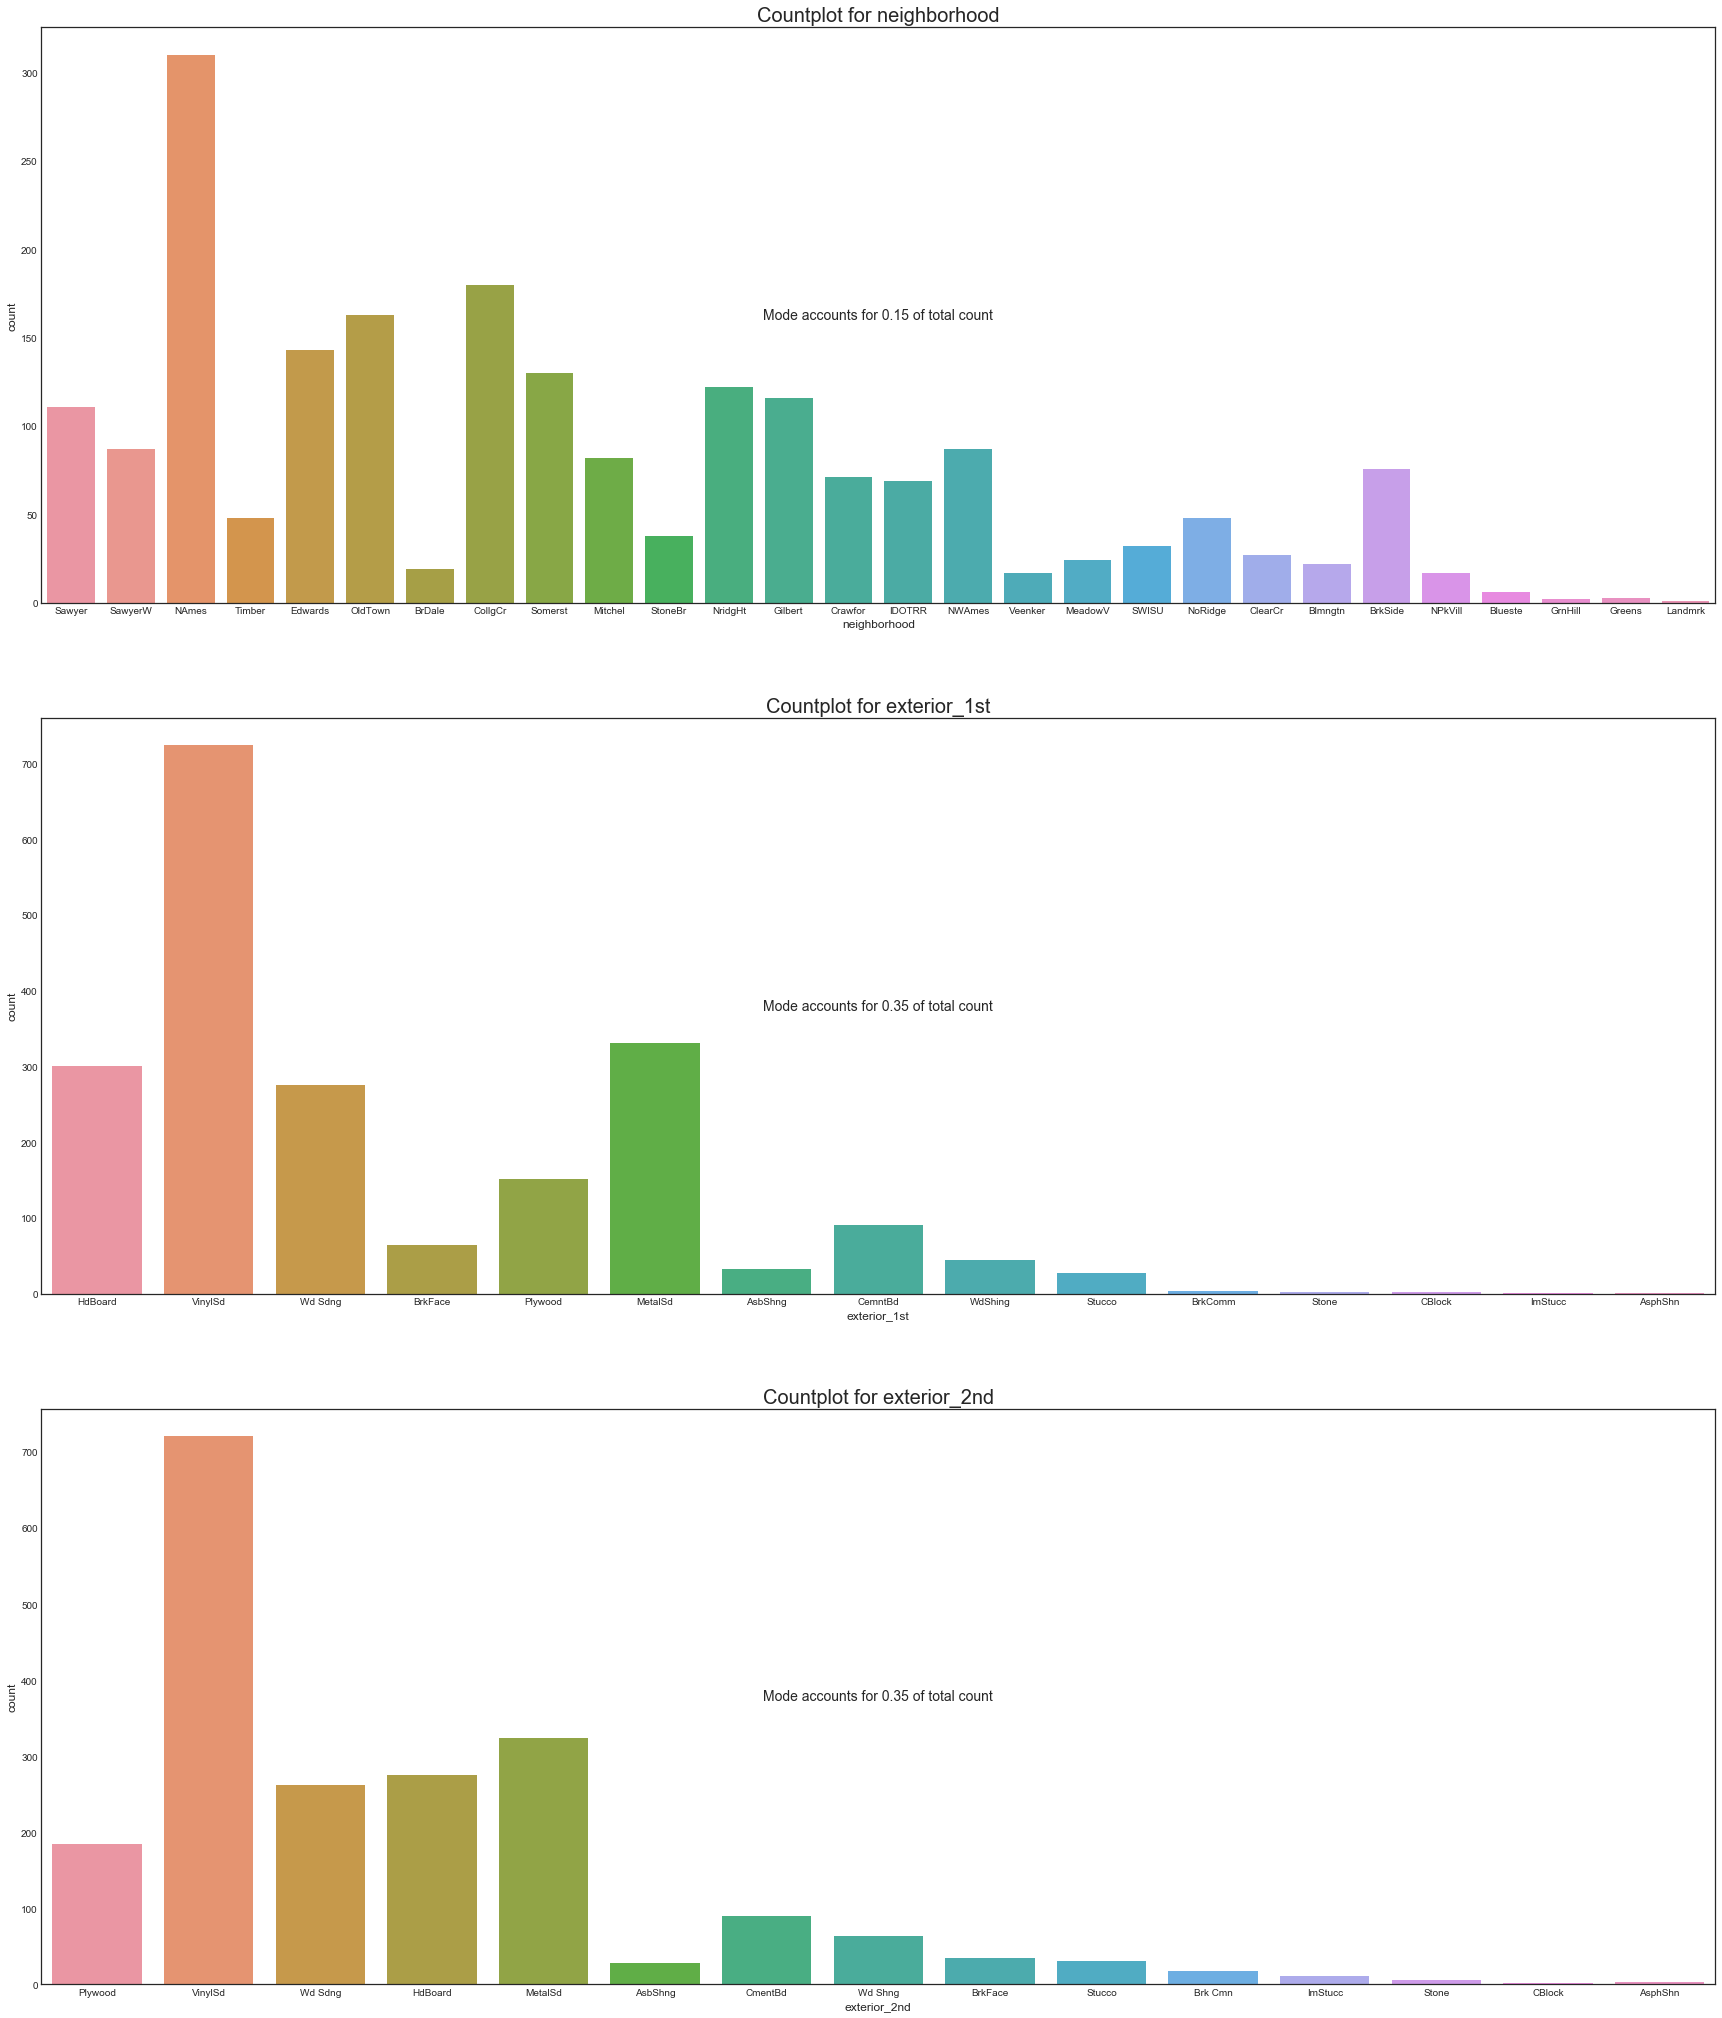

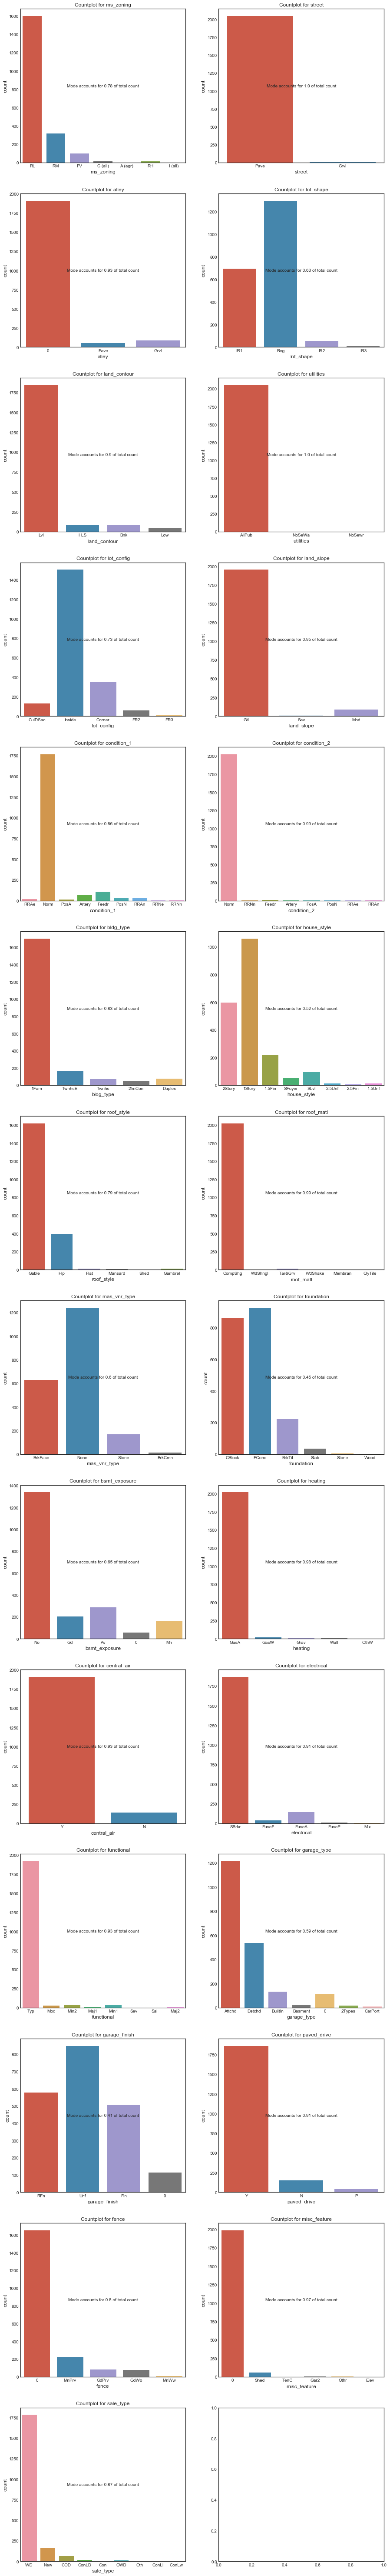

In [40]:
subplot_bars(df_train, list_of_columns)

#### Interpretation of count plots 

The purpose of the bar charts is to identify nominal features which are heavily skewed towards one category. Features that are heavily skewed will be encoded into binary values, rather than one hot encoding.

The following table summarizes the features that will be categorized into dichotomous variables.

### 4.1.3 Box plots <a id='boxplots'></a>

In [41]:
plt.style.use('ggplot')
def subplot_boxplots(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(15, len(list_of_columns)*2)) 
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i] = sns.boxplot(data = dataframe[column], width=0.3, ax=ax[i])
        ax[i].set_title("Boxplot for {}".format(list_of_columns[i]), fontsize = 12)

In [42]:
#Plot boxplots for all features that are floats or integers
list_of_columns = [i for i in df_train.columns if df_train[i].dtype=="float64" or df_train[i].dtype=="int64"]

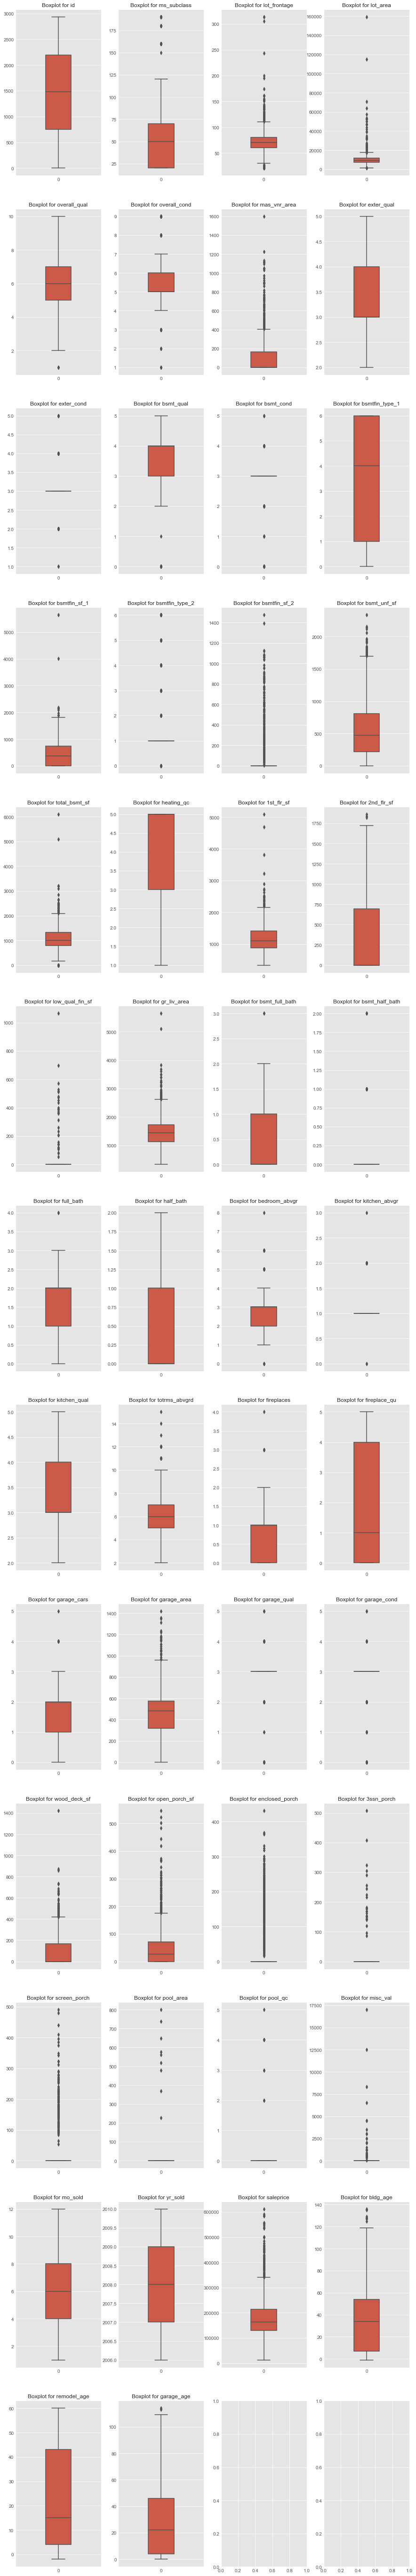

In [43]:
subplot_boxplots(df_train, list_of_columns)

#### Interpretation of Boxplots

Similar to what we have established in our bar plots, the boxplots highlight three main points:

     1) Very skewed data
     2) Presence of outliers
     3) Some of these features can be categorized dichotomously (i.e. binary)

# 4.2 : Correlation Visualizations and Analysis <a id='correlations'></a>
### 4.2.1 Scatter Plots <a id='scatters'></a>

In [44]:
#Plots seaborn regplot
plt.style.use('seaborn-white')
def subplot_scatter(dataframe, list_of_x, target):
    nrows = int(np.ceil(len(list_of_x)/2)) # Makes sure you have enough rows
    #tweak figsize scaler if graphs don't fit well
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, len(list_of_x)*4), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, x_axis in enumerate(list_of_x): # Gives us an index value to get into all our lists
        corr_val = round(dataframe[x_axis].corr(dataframe[target]), 2) #finds correlation value to print on graph
        sns.regplot(x = dataframe[x_axis], y = dataframe[target], data = dataframe, ax=ax[i])
        ax[i].set_title(list_of_x[i])
        ax[i].set_xlabel(list_of_x[i]) 
        ax[i].set_ylabel(target)
        ax[i].text(0.75, 0.95, "Correlation: {}".format(corr_val), ha="left", va="top", transform=ax[i].transAxes, fontsize=12)

In [45]:
#Plot scatters for all features that are floats or integers
list_of_x = [i for i in df_train.columns if df_train[i].dtype=="float64" or df_train[i].dtype=="int64"]

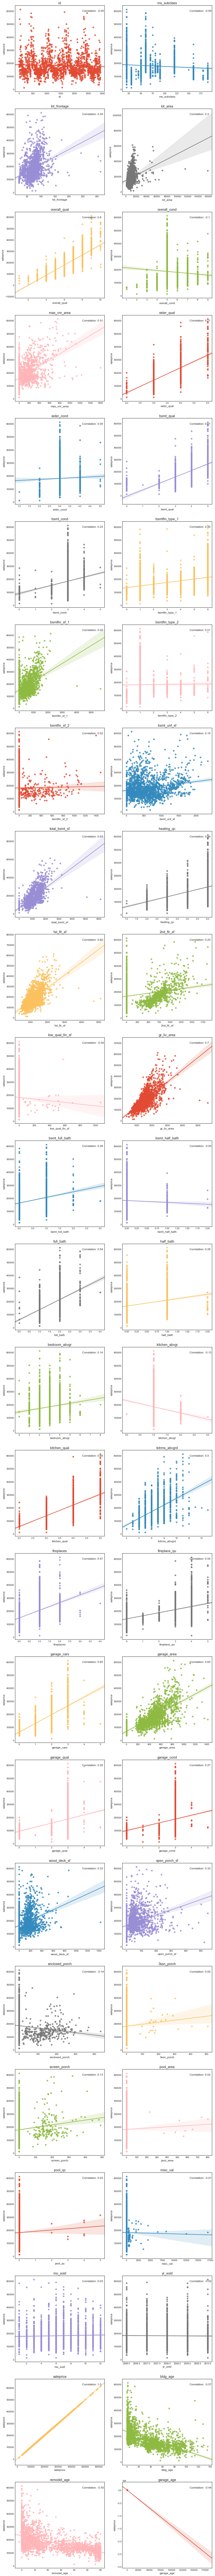

In [46]:
subplot_scatter(df_train, list_of_x, "saleprice")

In [47]:
#Plots seaborn stripplot
plt.style.use('seaborn-white')
def subplot_strip(dataframe, list_of_x, target):
    nrows = int(np.ceil(len(list_of_x)/2)) # Makes sure you have enough rows
    #tweak figsize scaler if graphs don't fit well
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, len(list_of_x)*4), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, x_axis in enumerate(list_of_x): # Gives us an index value to get into all our lists
        sns.stripplot(x = dataframe[x_axis], y = dataframe[target], data = dataframe, ax=ax[i])
        ax[i].set_title(list_of_x[i])
        ax[i].set_xlabel(list_of_x[i]) 
        ax[i].set_ylabel(target)


In [48]:
#list of categorical features to scatter
list_of_x = [i for i in df_train.columns if df_train[i].dtype=="object"]

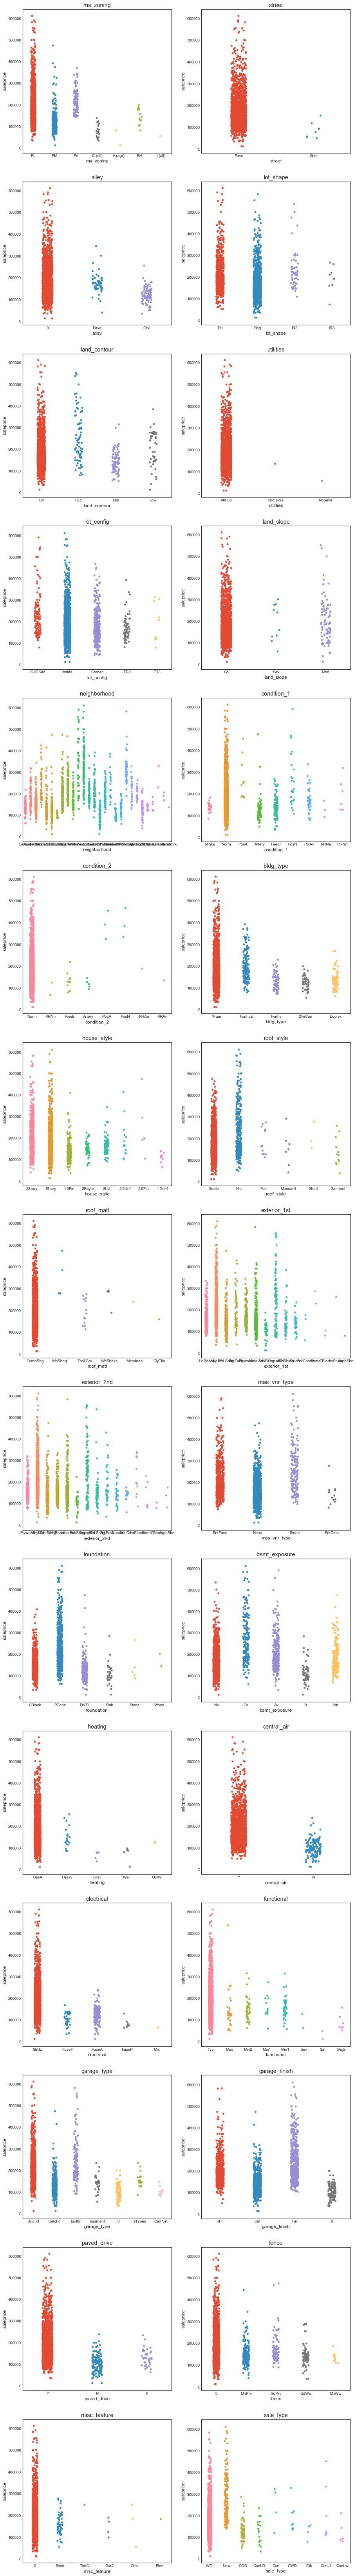

In [49]:
subplot_strip(df_train, list_of_x, "saleprice")

### 4.2.2 Heatmaps  <a id='heat'></a>

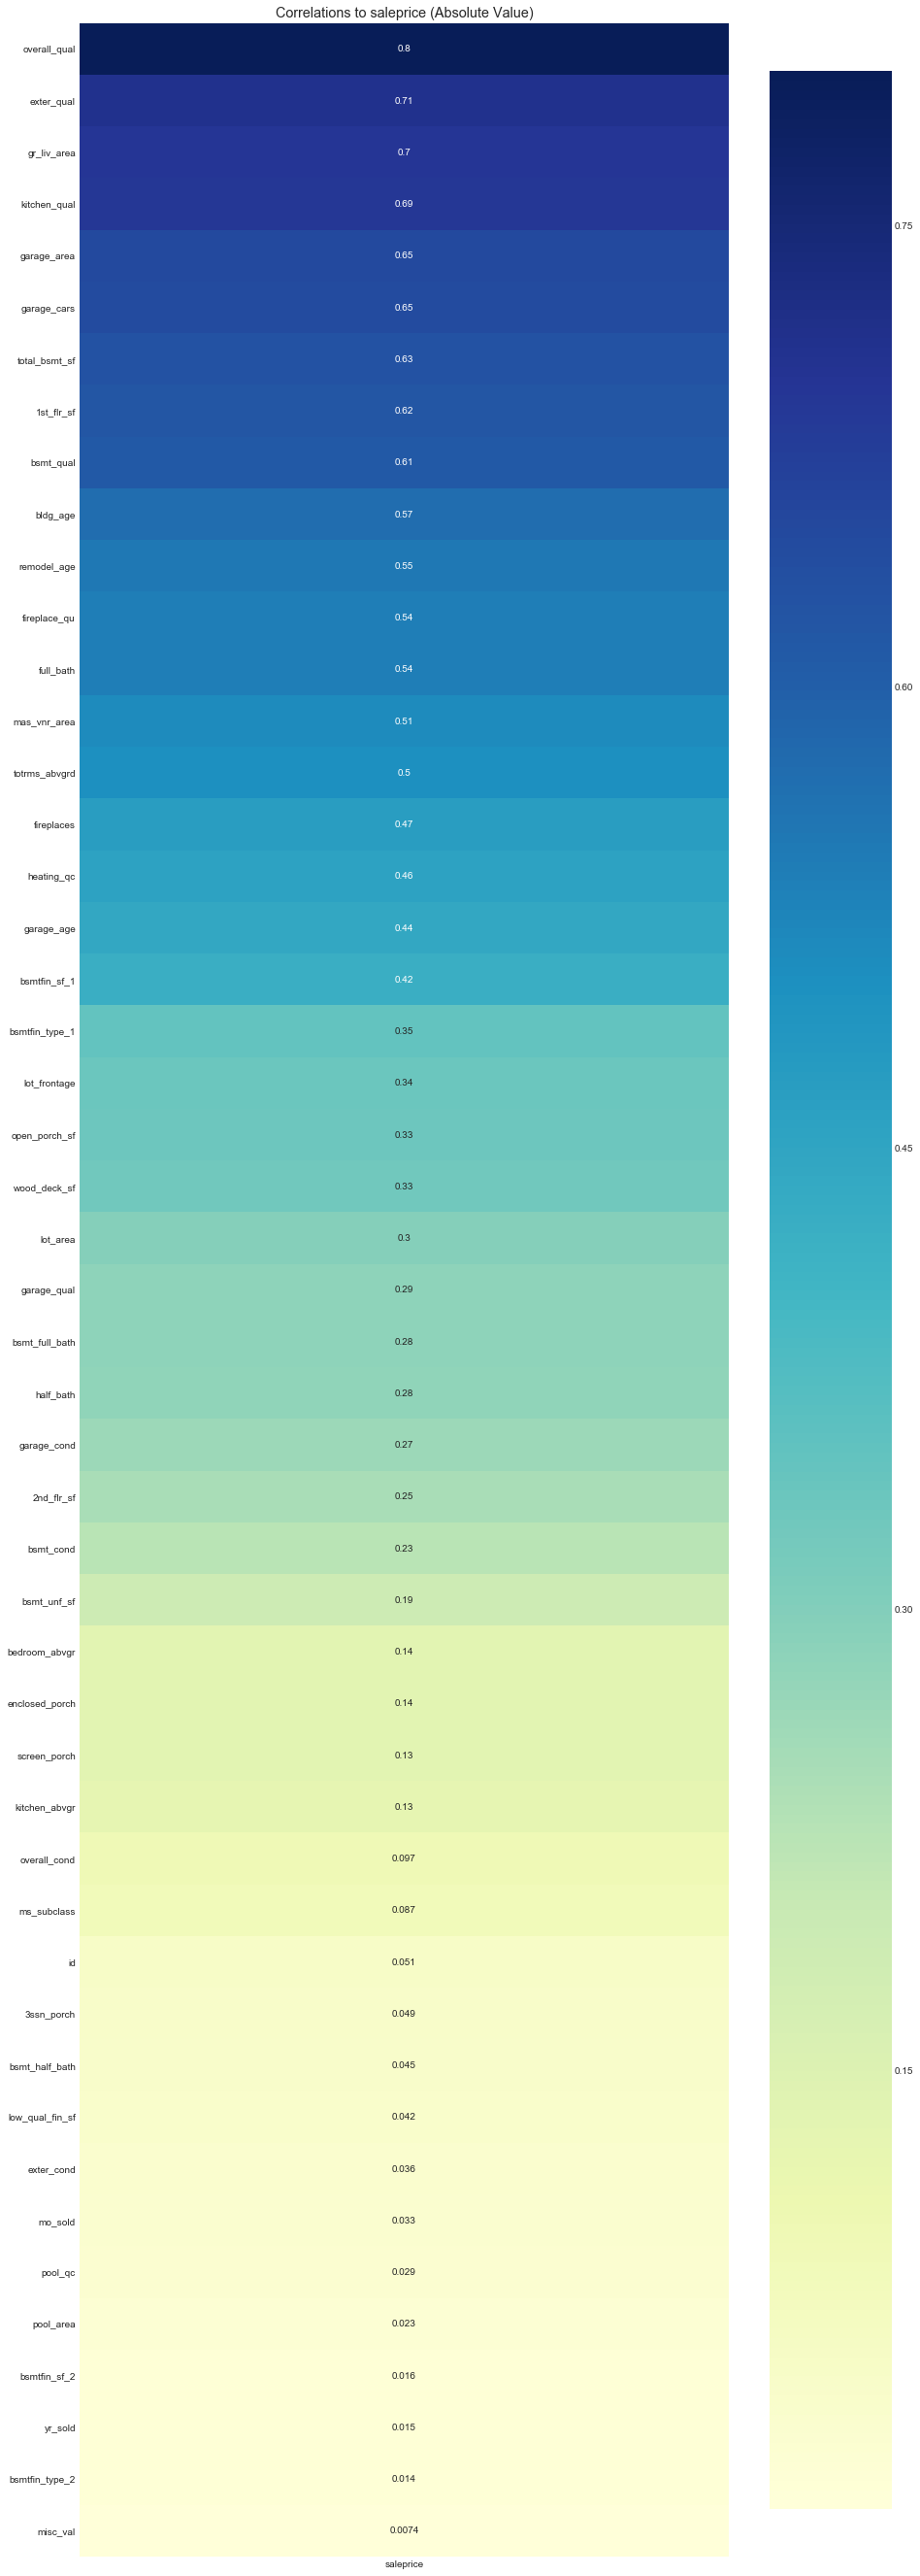

In [50]:
quick_heat(df_train, "saleprice", n=len(df_train.columns))

# 5. Encoding and Preprocessing <a id='prep'></a>

### 5.1 Removing Outliers 


Two outliers with very high square footage and low prices were identified in the EDA and will be removed from the training set.

In [51]:
#Review the outliers
df_train[df_train["1st_flr_sf"]>4500]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
960   1499           60        RL         313.0     63887   Pave     0   
1885  2181           20        RL         128.0     39290   Pave     0   

     lot_shape land_contour utilities lot_config land_slope neighborhood  \
960        IR3          Bnk    AllPub     Corner        Gtl      Edwards   
1885       IR1          Bnk    AllPub     Inside        Gtl      Edwards   

     condition_1 condition_2 bldg_type house_style  overall_qual  \
960        Feedr        Norm      1Fam      2Story            10   
1885        Norm        Norm      1Fam      1Story            10   

      overall_cond roof_style roof_matl exterior_1st exterior_2nd  \
960              5        Hip   ClyTile       Stucco       Stucco   
1885             5        Hip   CompShg      CemntBd      CmentBd   

     mas_vnr_type  mas_vnr_area  exter_qual  exter_cond foundation  bsmt_qual  \
960         Stone         796.0           5           3      PConc          5   
1885        Stone        1224.0           5           3      PConc          5   

      bsmt_cond bsmt_exposure  bsmtfin_type_1  bsmtfin_sf_1  bsmtfin_type_2  \
960           3            Gd               6        5644.0               1   
1885          3            Gd               6        4010.0               1   

      bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf heating  heating_qc  \
960            0.0        466.0         6110.0    GasA           5   
1885           0.0       1085.0         5095.0    GasA           5   

     central_air electrical  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  \
960            Y      SBrkr        4692         950                0   
1885           Y      SBrkr        5095           0                0   

      gr_liv_area  bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  \
960          5642             2.0             0.0          2          1   
1885         5095             1.0             1.0          2          1   

      bedroom_abvgr  kitchen_abvgr  kitchen_qual  totrms_abvgrd functional  \
960               3              1             5             12        Typ   
1885              2              1             5             15        Typ   

      fireplaces  fireplace_qu garage_type garage_finish  garage_cars  \
960            3             4      Attchd           Fin          2.0   
1885           2             4      Attchd           Fin          3.0   

      garage_area  garage_qual  garage_cond paved_drive  wood_deck_sf  \
960        1418.0            3            3           Y           214   
1885       1154.0            3            3           Y           546   

      open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  pool_area  \
960             292               0           0             0        480   
1885            484               0           0             0          0   

      pool_qc fence misc_feature  misc_val  mo_sold  yr_sold sale_type  \
960         4     0            0         0        1     2008       New   
1885        0     0         Elev     17000       10     2007       New   

      saleprice  bldg_age  remodel_age  garage_age  
960      160000         0            0         0.0  
1885     183850        -1           -2         0.0

In [52]:
df_train.drop(df_train[df_train["1st_flr_sf"]>4500].index, axis = 0, inplace = True)

### 5.2 Converting Categorical Data into Dichotomous Variables   <a id='binary'></a>

As highlighted in the EDA, there are several features where one feature makes up a significant proportion of the data.
For example, the "functional" feature has 8 categories, but "typ" makes up 93% of total values.

Rather than using one-hot encoding to create 7 columns for these features (where the count for each column may not be large enough to make it significant), I will be binarizing it. To follow on from the "functional" example, I will create a column "function_istyp" to indicate the presence of "typ" against the absence of "typ".

What the function below does is search through your entire data frame where the mode count as a % of total count is greater than a threshold and generates a dataframe from it. This dataframe can then be passed to a second function to create dummies in the dataframe. The reason why the functions are separate are so that I can review the data that get_binary_variables selects before changing my dataframe.

In [53]:
#The purpose of this function is to generate a dataframe with three columns of data.
#From the training set, it will find all features where the mode value is greater than x, and populate the table with
#it's associated information
def get_binary_variables(dataframe, threshold=0.5):

    #creates a list of all columns with data type = "object". These are assumed to be categorical data.
    nominal_list = [col for col in dataframe.columns if dataframe[col].dtype=="object"]
    binary_list = []
    mode_list = []
    mode_perc_list = []
    for col in dataframe[nominal_list]:
        #Finds the highest occuring categorical value, and returns its count as a percentage of total count
        mode_perc = np.round(dataframe[col].value_counts().max()/dataframe[col].value_counts().sum(), 2)
        if mode_perc > threshold:
            #Adds feature to list
            binary_list.append(col)
            #Adds mode of feature to list
            mode_list.append(dataframe[col].value_counts().idxmax())
            #Adds modeperc of feature to list
            mode_perc_list.append(mode_perc)
            
    return pd.DataFrame({"feature": binary_list,
                         "mode": mode_list,
                         "mode perc": mode_perc_list})

In [54]:
#Feed output from the get_binary_variables function into this
def create_binary_dummies(dataframe, binary_dataframe):
    for i in range(len(binary_dataframe)):
        #Creates a new column name with the feature name + the mode
        new_feature = binary_dataframe["feature"][i]+"_is"+str(binary_dataframe["mode"][i])
        #Creates a new dataframe column and applies the binary mapping function
        dataframe[new_feature] = dataframe[binary_dataframe["feature"][i]].apply(lambda x: 1 if x == binary_dataframe["mode"][i] else 0)
        #Drop original columns

In [55]:
binary_dataframe = get_binary_variables(df_train, threshold=0.6)
binary_dataframe

feature     mode  mode perc
0       ms_zoning       RL       0.78
1          street     Pave       1.00
2           alley        0       0.93
3       lot_shape      Reg       0.63
4    land_contour      Lvl       0.90
5       utilities   AllPub       1.00
6      lot_config   Inside       0.73
7      land_slope      Gtl       0.95
8     condition_1     Norm       0.86
9     condition_2     Norm       0.99
10      bldg_type     1Fam       0.83
11     roof_style    Gable       0.79
12      roof_matl  CompShg       0.99
13   mas_vnr_type     None       0.61
14  bsmt_exposure       No       0.65
15        heating     GasA       0.98
16    central_air        Y       0.93
17     electrical    SBrkr       0.91
18     functional      Typ       0.93
19    paved_drive        Y       0.91
20          fence        0       0.80
21   misc_feature        0       0.97
22      sale_type      WD        0.87

In [56]:
create_binary_dummies(df_train, binary_dataframe)

In [57]:
#Drop original features that were dummied
df_train.drop(binary_dataframe["feature"], axis = 1, inplace=True)

In [58]:
df_train.head(3)

id  ms_subclass  lot_frontage  lot_area neighborhood house_style  \
0  109           60          72.0     13517       Sawyer      2Story   
1  544           60          43.0     11492      SawyerW      2Story   
2  153           20          68.0      7922        NAmes      1Story   

   overall_qual  overall_cond exterior_1st exterior_2nd  mas_vnr_area  \
0             6             8      HdBoard      Plywood         289.0   
1             7             5      VinylSd      VinylSd         132.0   
2             5             7      VinylSd      VinylSd           0.0   

   exter_qual  exter_cond foundation  bsmt_qual  bsmt_cond  bsmtfin_type_1  \
0           4           3     CBlock          3          3               6   
1           4           3      PConc          4          3               6   
2           3           4     CBlock          3          3               6   

   bsmtfin_sf_1  bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  \
0         533.0               1           0.0        192.0          725.0   
1         637.0               1           0.0        276.0          913.0   
2         731.0               1           0.0        326.0         1057.0   

   heating_qc  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0           5         725         754                0         1479   
1           5         913        1209                0         2122   
2           3        1057           0                0         1057   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   

   kitchen_abvgr  kitchen_qual  totrms_abvgrd  fireplaces  fireplace_qu  \
0              1             4              6           0             0   
1              1             4              8           1             3   
2              1             4              5           0             0   

  garage_type garage_finish  garage_cars  garage_area  garage_qual  \
0      Attchd           RFn          2.0        475.0            3   
1      Attchd           RFn          2.0        559.0            3   
2      Detchd           Unf          1.0        246.0            3   

   garage_cond  wood_deck_sf  open_porch_sf  enclosed_porch  3ssn_porch  \
0            3             0             44               0           0   
1            3             0             74               0           0   
2            3             0             52               0           0   

   screen_porch  pool_area  pool_qc  misc_val  mo_sold  yr_sold  saleprice  \
0             0          0        0         0        3     2010     130500   
1             0          0        0         0        4     2009     220000   
2             0          0        0         0        1     2010     109000   

   bldg_age  remodel_age  garage_age  ms_zoning_isRL  street_isPave  \
0        34            5        34.0               1              1   
1        13           12        12.0               1              1   
2        57            3        57.0               1              1   

   alley_is0  lot_shape_isReg  land_contour_isLvl  utilities_isAllPub  \
0          1                0                   1                   1   
1          1                0                   1                   1   
2          1                1                   1                   1   

   lot_config_isInside  land_slope_isGtl  condition_1_isNorm  \
0                    0                 1                   0   
1                    0                 1                   1   
2                    1                 1                   1   

   condition_2_isNorm  bldg_type_is1Fam  roof_style_isGable  \
0                   1                 1                   1   
1                   1                 1                   1  

In [59]:
binary_dataframe = get_binary_variables(df_test, threshold=0.6)
binary_dataframe

feature     mode  mode perc
0       ms_zoning       RL       0.77
1          street     Pave       0.99
2           alley        0       0.93
3       lot_shape      Reg       0.64
4    land_contour      Lvl       0.90
5       utilities   AllPub       1.00
6      lot_config   Inside       0.72
7      land_slope      Gtl       0.95
8     condition_1     Norm       0.86
9     condition_2     Norm       1.00
10      bldg_type     1Fam       0.82
11     roof_style    Gable       0.80
12      roof_matl  CompShg       0.98
13   mas_vnr_type     None       0.61
14  bsmt_exposure       No       0.65
15        heating     GasA       0.99
16    central_air        Y       0.94
17     electrical    SBrkr       0.93
18     functional      Typ       0.92
19    paved_drive        Y       0.90
20          fence        0       0.80
21   misc_feature        0       0.95
22      sale_type      WD        0.86

In [60]:
df_train.shape

(2049, 80)

In [61]:
create_binary_dummies(df_test, binary_dataframe)

In [62]:
#Drop original features that were dummied
df_test.drop(binary_dataframe["feature"], axis = 1, inplace=True)

In [63]:
df_test.head(3)

id  ms_subclass  lot_frontage  lot_area neighborhood house_style  \
0  2658          190          69.0      9142      OldTown      2Story   
1  2718           90          85.0      9662       Sawyer      1Story   
2  2414           60          58.0     17104      Gilbert      2Story   

   overall_qual  overall_cond exterior_1st exterior_2nd  mas_vnr_area  \
0             6             8      AsbShng      AsbShng           0.0   
1             5             4      Plywood      Plywood           0.0   
2             7             5      VinylSd      VinylSd           0.0   

   exter_qual  exter_cond foundation  bsmt_qual  bsmt_cond  bsmtfin_type_1  \
0           3           2      Stone          2          3               1   
1           3           3     CBlock          4          3               1   
2           4           3      PConc          4          4               6   

   bsmtfin_sf_1  bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  \
0             0               1             0         1020           1020   
1             0               1             0         1967           1967   
2           554               1             0          100            654   

   heating_qc  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0           4         908        1020                0         1928   
1           3        1967           0                0         1967   
2           5         664         832                0         1496   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0               0               0          2          0              4   
1               0               0          2          0              6   
2               1               0          2          1              3   

   kitchen_abvgr  kitchen_qual  totrms_abvgrd  fireplaces  fireplace_qu  \
0              2             2              9           0             0   
1              2             3             10           0             0   
2              1             4              7           1             4   

  garage_type garage_finish  garage_cars  garage_area  garage_qual  \
0      Detchd           Unf            1          440            1   
1      Attchd           Fin            2          580            3   
2      Attchd           RFn            2          426            3   

   garage_cond  wood_deck_sf  open_porch_sf  enclosed_porch  3ssn_porch  \
0            1             0             60             112           0   
1            3           170              0               0           0   
2            3           100             24               0           0   

   screen_porch  pool_area  pool_qc  misc_val  mo_sold  yr_sold  bldg_age  \
0             0          0        0         0        4     2006        96   
1             0          0        0         0        8     2006        29   
2             0          0        0         0        9     2006         0   

   remodel_age  garage_age  ms_zoning_isRL  street_isPave  alley_is0  \
0           56        96.0               0              1          0   
1           29        29.0               1              1          1   
2            0         0.0               1              1          1   

   lot_shape_isReg  land_contour_isLvl  utilities_isAllPub  \
0                1                   1                   1   
1                0                   1                   1   
2                0                   1                   1   

   lot_config_isInside  land_slope_isGtl  condition_1_isNorm  \
0                    1                 1                   1   
1                    1                 1                   1   
2                    1                 1                   1   

   condition_2_isNorm  bldg_type_is1Fam  roof_style_isGable  \
0                   1                 0                   1   
1                   1                 0                   1   
2                   1                 1

In [64]:
df_test.shape

(879, 79)

### 5.3 One-hot encoding for remaining categorical data <a id='dummy'></a>

In [65]:
onehot_list = [col for col in df_train.columns if df_train[col].dtype=="object"]

In [66]:
df_train_cleaned = pd.get_dummies(data = df_train, columns = onehot_list, prefix = onehot_list, prefix_sep = "_", drop_first = True)

In [67]:
onehot_list = [col for col in df_test.columns if df_test[col].dtype=="object"]

In [68]:
df_test_cleaned = pd.get_dummies(data = df_test, columns = onehot_list, prefix = onehot_list, prefix_sep = "_", drop_first = True)

# 6. Exporting Cleaned Data <a id='export'></a>

In [69]:
df_train_cleaned.to_csv(r".\datasets\train_cleaned2.csv")

df_test_cleaned.to_csv(r".\datasets\test_cleaned2.csv")